In [1]:
import bz2
import os
import os.path as osp
import sys
import cv2

import dlib
import numpy as np
import PIL.Image
import requests
import scipy.ndimage
from tqdm import tqdm

LANDMARKS_MODEL_URL = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'

### align

In [2]:
class LandmarksDetector:
    def __init__(self, predictor_model_path):
        """
        :param predictor_model_path: path to shape_predictor_68_face_landmarks.dat file
        """
        self.detector = dlib.get_frontal_face_detector(
        )  # cnn_face_detection_model_v1 also can be used
        self.shape_predictor = dlib.shape_predictor(predictor_model_path)

    def get_landmarks(self, image):
        img = cv2.imread(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        dets = self.detector(img, 1)

        for detection in dets:
            face_landmarks = [
                (item.x, item.y)
                for item in self.shape_predictor(img, detection).parts()
            ]
            return face_landmarks


def unpack_bz2(src_path):
    dst_path = src_path[:-4]
    if os.path.exists(dst_path):
        print('cached')
        return dst_path
    data = bz2.BZ2File(src_path).read()
    with open(dst_path, 'wb') as fp:
        fp.write(data)
    return dst_path


def work_landmark(raw_img_path, img_name, face_landmarks):
    face_img_name = '%s.jpg' % (os.path.splitext(img_name)[0], )
    aligned_face_path = os.path.join(ALIGNED_IMAGES_DIR, face_img_name)
    if os.path.exists(aligned_face_path):
        return
    image_align(raw_img_path,
                aligned_face_path,
                face_landmarks,
                output_size=256)


def get_file(src, tgt):
    if os.path.exists(tgt):
        print('cached')
        return tgt
    tgt_dir = os.path.dirname(tgt)
    if not os.path.exists(tgt_dir):
        os.makedirs(tgt_dir)
    file = requests.get(src)
    open(tgt, 'wb').write(file.content)
    return tgt

In [3]:
def image_align(src_file,
                dst_file,
                face_landmarks,
                output_size=1024,
                transform_size=4096,
                enable_padding=True):
    # Align function from FFHQ dataset pre-processing step
    # https://github.com/NVlabs/ffhq-dataset/blob/master/download_ffhq.py

    lm = np.array(face_landmarks)
    lm_chin = lm[0:17]  # left-right
    lm_eyebrow_left = lm[17:22]  # left-right
    lm_eyebrow_right = lm[22:27]  # left-right
    lm_nose = lm[27:31]  # top-down
    lm_nostrils = lm[31:36]  # top-down
    lm_eye_left = lm[36:42]  # left-clockwise
    lm_eye_right = lm[42:48]  # left-clockwise
    lm_mouth_outer = lm[48:60]  # left-clockwise
    lm_mouth_inner = lm[60:68]  # left-clockwise

    # Calculate auxiliary vectors.
    eye_left = np.mean(lm_eye_left, axis=0)
    eye_right = np.mean(lm_eye_right, axis=0)
    eye_avg = (eye_left + eye_right) * 0.5
    eye_to_eye = eye_right - eye_left
    mouth_left = lm_mouth_outer[0]
    mouth_right = lm_mouth_outer[6]
    mouth_avg = (mouth_left + mouth_right) * 0.5
    eye_to_mouth = mouth_avg - eye_avg

    # Choose oriented crop rectangle.
    x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
    x /= np.hypot(*x)
    x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
    y = np.flipud(x) * [-1, 1]
    c = eye_avg + eye_to_mouth * 0.1
    quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
    qsize = np.hypot(*x) * 2
    
    # Load in-the-wild image.
    if not os.path.isfile(src_file):
        print(
            '\nCannot find source image. Please run "--wilds" before "--align".'
        )
        return
    img = PIL.Image.open(src_file)
    img = img.convert('RGB')

    # Shrink.
    shrink = int(np.floor(qsize / output_size * 0.5))
    if shrink > 1:
        rsize = (int(np.rint(float(img.size[0]) / shrink)),
                 int(np.rint(float(img.size[1]) / shrink)))
        img = img.resize(rsize, PIL.Image.ANTIALIAS)
        quad /= shrink
        qsize /= shrink

    # Crop.
    border = max(int(np.rint(qsize * 0.1)), 3)
    crop = (int(np.floor(min(quad[:, 0]))), int(np.floor(min(quad[:, 1]))),
            int(np.ceil(max(quad[:, 0]))), int(np.ceil(max(quad[:, 1]))))
    crop = (max(crop[0] - border, 0), max(crop[1] - border, 0),
            min(crop[2] + border,
                img.size[0]), min(crop[3] + border, img.size[1]))
    if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
        img = img.crop(crop)
        quad -= crop[0:2]

    # Pad.
    pad = (int(np.floor(min(quad[:, 0]))), int(np.floor(min(quad[:, 1]))),
           int(np.ceil(max(quad[:, 0]))), int(np.ceil(max(quad[:, 1]))))
    pad = (max(-pad[0] + border,
               0), max(-pad[1] + border,
                       0), max(pad[2] - img.size[0] + border,
                               0), max(pad[3] - img.size[1] + border, 0))
    if enable_padding and max(pad) > border - 4:
        pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
        img = np.pad(np.float32(img),
                     ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
        h, w, _ = img.shape
        y, x, _ = np.ogrid[:h, :w, :1]
        mask = np.maximum(
            1.0 -
            np.minimum(np.float32(x) / pad[0],
                       np.float32(w - 1 - x) / pad[2]), 1.0 -
            np.minimum(np.float32(y) / pad[1],
                       np.float32(h - 1 - y) / pad[3]))
        blur = qsize * 0.02
        img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) -
                img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
        img += (np.median(img, axis=(0, 1)) - img) * np.clip(mask, 0.0, 1.0)
        img = PIL.Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)),
                                  'RGB')
        quad += pad[:2]

    # Transform.
    img = img.transform((transform_size, transform_size), PIL.Image.QUAD,
                        (quad + 0.5).flatten(), PIL.Image.BILINEAR)
    if output_size < transform_size:
        img = img.resize((output_size, output_size), PIL.Image.ANTIALIAS)

    # Save aligned image.
    img.save(dst_file, quality=95)

In [4]:
landmarks_model_path = unpack_bz2(
    get_file(
        'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2',
        'temp/shape_predictor_68_face_landmarks.dat.bz2'))

RAW_IMAGES_DIR = "videos/video_frames"
ALIGNED_IMAGES_DIR = "videos/video_frames_align_fixed"

if not osp.exists(ALIGNED_IMAGES_DIR): os.makedirs(ALIGNED_IMAGES_DIR)

files = os.listdir(RAW_IMAGES_DIR)
num_files = len(files)
print(f'total img files {num_files}')
landmarks_detector = LandmarksDetector(landmarks_model_path)
first_raw_img_path = osp.join(RAW_IMAGES_DIR, files[0])
face_landmarks = landmarks_detector.get_landmarks(first_raw_img_path)

with tqdm(total=num_files) as progress:
    for i,img_name in enumerate(files):
        raw_img_path = osp.join(RAW_IMAGES_DIR, img_name)            
        work_landmark(raw_img_path, img_name, face_landmarks)
        progress.update()

# print(f"output aligned images at: {ALIGNED_IMAGES_DIR}")

cached
cached
total img files 168


100%|████████████████████████████████████████████████| 168/168 [00:00<00:00, 24005.83it/s]


In [5]:
IMAGES = []
align_imgs = os.listdir(ALIGNED_IMAGES_DIR)
for i in align_imgs:
    if i == '.ipynb.checkpoints':
        continue
    img_path = osp.join(ALIGNED_IMAGES_DIR, i)
    img = PIL.Image.open(img_path)
    IMAGES.append(img)

num_imgs = len(IMAGES)

### landmarkから目と口の矩形選択

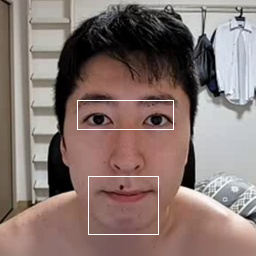

In [6]:
landmarks = []
align_imgs = os.listdir(ALIGNED_IMAGES_DIR)
for i in align_imgs:
    if i == '.ipynb.checkpoints':
        continue
    img_path = osp.join(ALIGNED_IMAGES_DIR, i)
    landmarks.append(landmarks_detector.get_landmarks(img_path))
    
landmarks = np.array(landmarks)

landmarks_eye = landmarks[:,36:48,:]
landmarks_eye_min = landmarks_eye.min(axis=0).min(axis=0)
landmarks_eye_max = landmarks_eye.max(axis=0).max(axis=0)

landmarks_mouth = landmarks[:,48:60,:]
landmarks_mouth_min = landmarks_mouth.min(axis=0).min(axis=0)
landmarks_mouth_max = landmarks_mouth.max(axis=0).max(axis=0)

eyePoint = [*(landmarks_eye_min-5), *(landmarks_eye_max+5)]
mouthPoint = [landmarks_mouth_min[0]-5, landmarks_mouth_min[1], *(landmarks_mouth_max+5)]
points = []
points.append(eyePoint)
points.append(mouthPoint)

lineColor = (255,255,255)
img = np.array(IMAGES[0])
for i in points:
    pt1 = i[0:2]
    pt2 = i[2:]
    image = cv2.rectangle(img, pt1=pt1, pt2=pt2, color=lineColor)
PIL.Image.fromarray(image)

In [7]:
material_path = './imgs_material'
if not osp.exists(material_path):
    os.makedirs(material_path)

size=(eyePoint[3]-eyePoint[1],eyePoint[2]-eyePoint[0])
black_img=np.zeros(size,np.uint8)
eye_white_img=black_img+255
cv2.imwrite(material_path+'/eyewhite.jpg',eye_white_img)

size=(mouthPoint[3]-mouthPoint[1],mouthPoint[2]-mouthPoint[0])
black_img=np.zeros(size,np.uint8)
mouth_white_img=black_img+255
cv2.imwrite(material_path+'/mouthwhite.jpg',mouth_white_img)

src = cv2.imread(material_path+'/eyewhite.jpg')
dst = np.array(IMAGES[0])
src_mask = 255 * np.ones(src.shape, src.dtype)

vertical = int((eyePoint[3]+eyePoint[1])/2)
horizontal = int((eyePoint[2]+eyePoint[0])/2)
center = (horizontal,vertical)

output = cv2.seamlessClone(src, dst, src_mask, center, cv2.NORMAL_CLONE)
output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

pil_img = PIL.Image.fromarray(output)

In [8]:
no_EYE = []
src = cv2.imread(material_path+'/eyewhite.jpg')
src_mask = 255 * np.ones(src.shape, src.dtype)

vertical = int((eyePoint[3]+eyePoint[1])/2)
horizontal = int((eyePoint[2]+eyePoint[0])/2)
center = (horizontal,vertical)

for i in range(num_imgs):
    dst = np.array(IMAGES[i])
    output = cv2.seamlessClone(src, dst, src_mask, center, cv2.NORMAL_CLONE)
    pil_img = PIL.Image.fromarray(output)
    no_EYE.append(pil_img)

no_IMAGES = []
src = cv2.imread(material_path+'/mouthwhite.jpg')
src_mask = 255 * np.ones(src.shape, src.dtype)

vertical = int((mouthPoint[3]+mouthPoint[1])/2)
horizontal = int((mouthPoint[2]+mouthPoint[0])/2)
center = (horizontal,vertical)

for i in range(num_imgs):
    dst = np.array(no_EYE[i])
    output = cv2.seamlessClone(src, dst, src_mask, center, cv2.NORMAL_CLONE)
    pil_img = PIL.Image.fromarray(output)
    no_IMAGES.append(pil_img)
    
eye_CROPS = []
mouth_CROPS = []
for i in range(num_imgs):
    eye_CROPS.append(IMAGES[i].crop(eyePoint))
    mouth_CROPS.append(IMAGES[i].crop(mouthPoint))
    
eye_IMAGES = []
mouth_IMAGES = []
for i in range(num_imgs):
    eye_IMAGES.append(IMAGES[0].copy())
    mouth_IMAGES.append(IMAGES[0].copy())
    
EYE_IMAGES = []
for i in range(num_imgs):
    src = np.array(eye_CROPS[i])
    src_mask = 255 * np.ones(src.shape, src.dtype)
    vertical = int((eyePoint[3]+eyePoint[1])/2)
    horizontal = int((eyePoint[2]+eyePoint[0])/2)
    center = (horizontal,vertical)
    dst = np.array(IMAGES[0])
    output = cv2.seamlessClone(src, dst, src_mask, center, cv2.NORMAL_CLONE)
    pil_img = PIL.Image.fromarray(output)
    EYE_IMAGES.append(pil_img)

MOUTH_IMAGES = []
for i in range(num_imgs):
    src = np.array(mouth_CROPS[i])
    src_mask = 255 * np.ones(src.shape, src.dtype)
    vertical = int((mouthPoint[3]+mouthPoint[1])/2)
    horizontal = int((mouthPoint[2]+mouthPoint[0])/2)
    center = (horizontal,vertical)
    dst = np.array(IMAGES[0])
    output = cv2.seamlessClone(src, dst, src_mask, center, cv2.NORMAL_CLONE)
    pil_img = PIL.Image.fromarray(output)
    MOUTH_IMAGES.append(pil_img)

In [9]:
IMAGES_QUANTIZED = []
for i in IMAGES:
  IMAGES_QUANTIZED.append(i.quantize())

if not osp.exists('imgs_test/results'):
    os.makedirs('imgs_test/results')

IMAGES_QUANTIZED[0].save(
    "imgs_test/results/answer_fixed.gif",
    format="gif",
    save_all=True,
    append_images=IMAGES_QUANTIZED,
    duration=33,
    loop=0,
)

In [10]:
MOUTH_IMAGES_QUANTIZED = []
for i in MOUTH_IMAGES:
  MOUTH_IMAGES_QUANTIZED.append(i.quantize())

MOUTH_IMAGES_QUANTIZED[0].save(
    "imgs_test/results/answer_mouth_fixed.gif",
    format="gif",
    save_all=True,
    append_images=MOUTH_IMAGES_QUANTIZED,
    duration=33,
    loop=0,
)